In [1]:

# This is lzl's snippet for diploma project
import math
import os,shutil
import random
import warnings
import gc

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import seaborn as sns
from shapely.geometry import LineString, Point, Polygon
from shapely.wkt import dumps, loads
from tqdm import tqdm

import traProject as tp
from traProject.analysisFuns import statisticFuns as sfuns
from traProject.basicFuns import CalFuns as cfun,VisFuns as vfun,DataProcessingFuns as dfun
from traProject.classificationFuns import models
import traProject.utils as tu

random.seed(1229)

# plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# sns.set(font='SimHei',font_scale=1.5)  # 解决Seaborn中文显示问题并调整字体大小

warnings.filterwarnings("ignore")

picOut='../../output/pic/paper/'


# 低速数据分析

In [69]:
# test=pd.read_csv('../../output/paper/特征测试/特征测试_velocity_剔除遮挡及wifi_velocity.csv')
# wlist=[]
# for i in range(len(test)):
#     if test.loc[i,'Vmean']>test.loc[i,'maxspeed']:
#         wlist.append(test.loc[i,'linkID'])
# path0='../../output/paper/轨迹_按link_id_v1/'
# path1=tu.scan_files(path0)
# roadpath='../../output/paper/武汉路网/WUHAN_new.csv'
# for p in tqdm(path1):
#     vfun.visTra1(p,roadpath,picOut,drawR=wlist)

In [70]:
test=pd.read_csv('../../output/paper/FE/tra_speed2_dropViaduct=True_dropWifi=True_vTopNmode=1_0.5_velocity=velocity.csv')
wlist=[]
for i in range(len(test)):
    if test.loc[i,'Vmean']>test.loc[i,'maxspeed']:
        wlist.append(test.loc[i,'linkID'])
path0='../../output/paper/tra_linkid/tra_link_id_v2_Pts_minN=50_bufR=1e-05_dropWifi=False_velocity=velocity/'
path1=tu.scan_files(path0)
for src_path in path1:
    src_path=src_path.replace('\\','/')
    pname=src_path.split('/')[-2]
    fname=src_path.split('/')[-1]
    check=fname.split('.')[0]
    if check in wlist:
        dst_path=tu.pathCheck('../../output/paper/wrongSample/%s/'%(pname))+fname
        shutil.copyfile(src_path, dst_path)

../../output/paper/wrongSample/maxspeed=20\132654911-5.csv


count    370.000000
mean      21.656374
std        8.156396
min        6.294040
25%       15.209058
50%       20.990007
75%       26.725562
max       47.660141
Name: speed2, dtype: float64

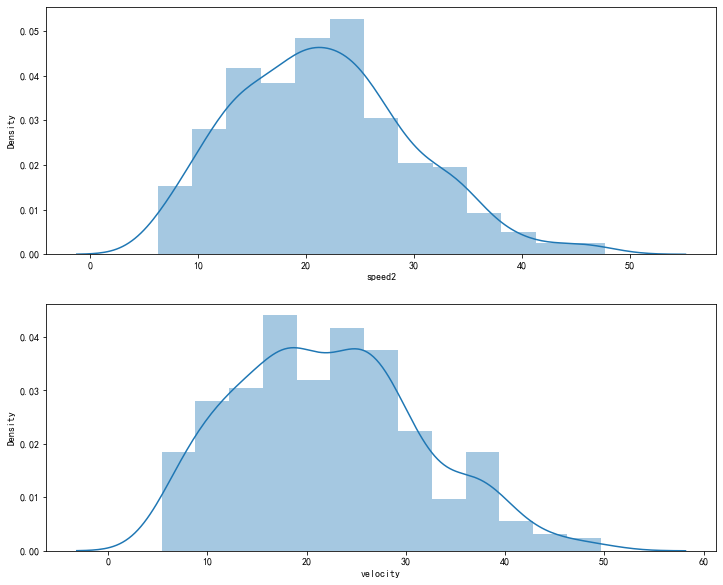

In [71]:
speedName='speed2'
proFlie='../../output/paper/wrongSample/'
proList=tu.scan_files(proFlie)
p=proList[3]
print(p)
# for p in proList:
p=p.replace('\\','/')
data=pd.read_csv(p)
data=data[data.type==0]
speed=data[speedName]
velocity=tu.vFilter(data,vlimt=[5, 120],speedName='velocity').velocity
# speed.describe(),velocity.describe()
fig,ax=plt.subplots(2,1,figsize=[12,10],sharex=False)
sns.distplot(speed,ax=ax[0])
sns.distplot(velocity,ax=ax[1])
speed.describe()

In [72]:
sum(data.speed>20)/len(data),sum(data.speed2>20)/len(data),sum(data.velocity>20)/len(data),sum(data.velocity1>20)/len(data)

(0.5162162162162162,
 0.5648648648648649,
 0.5459459459459459,
 0.4756756756756757)

../../output/paper/wrongSample/maxspeed=60\107313709-0.csv


count    665.000000
mean      62.429525
std        9.739020
min       35.820294
25%       55.584945
50%       62.895904
75%       68.815450
max       89.429310
Name: speed2, dtype: float64

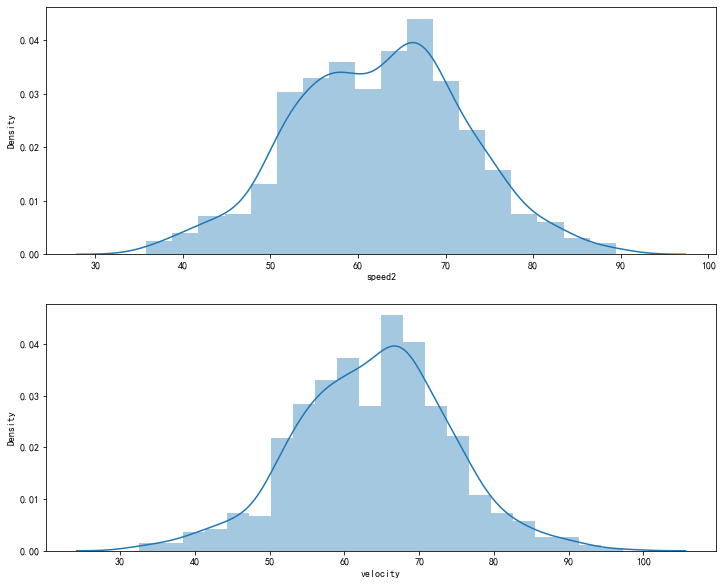

In [73]:
speedName='speed2'
proFlie='../../output/paper/wrongSample/'
proList=tu.scan_files(proFlie)
p=proList[-3]
print(p)
# for p in proList:
p=p.replace('\\','/')
data=pd.read_csv(p)
data=data[data.type==0]
speed=data[speedName]
velocity=tu.vFilter(data,vlimt=[5, 120],speedName='velocity').velocity
# speed.describe(),velocity.describe()
fig,ax=plt.subplots(2,1,figsize=[12,10],sharex=False)
sns.distplot(speed,ax=ax[0])
sns.distplot(velocity,ax=ax[1])
speed.describe()

In [74]:
sum(data.speed>60)/len(data),sum(data.speed2>60)/len(data),sum(data.velocity>60)/len(data),sum(data.velocity1>60)/len(data)

(0.5609022556390978,
 0.5864661654135338,
 0.6601503759398496,
 0.5609022556390978)

In [75]:
out1=pd.DataFrame(wlist)
out1['tag']=1
out1.to_csv('../../output/paper/wrongSample/wlist.csv')

In [76]:
test=pd.read_csv('../../output/paper/特征测试/特征测试_newspeed.csv')
wlist=[]
all_list=[]
for i in range(len(test)):
    all_list.append(test.loc[i,'linkID'])
    if test.loc[i,'Vmean']>=test.loc[i,'maxspeed']:
        wlist.append(test.loc[i,'linkID'])
road_all=pd.read_csv('../../output/paper/武汉路网/WUHAN_new.csv')
test=road_all[road_all.link_id.isin(wlist)]
test.reset_index(drop=True,inplace=True)
alld=road_all[road_all.link_id.isin(all_list)]
alld.reset_index(drop=True,inplace=True)
print(list(alld))

# by='fclass'#改这个
by='maxspeed'#改这个

x=pd.DataFrame(test.groupby(by).osm_id.count())
x.reset_index(inplace=True)
y=pd.DataFrame(alld.groupby(by).osm_id.count())
y.reset_index(inplace=True)
y.columns=[by,'allNum']
y[['wrongNum','wrongRate']]=0
for i in range(len(x)):
    idx=x.loc[i,by]
    wnum=x.loc[i,'osm_id']
    y.loc[y[by]==idx,'wrongNum']=wnum
y.wrongRate=y.wrongNum/y.allNum
y.sort_values(by='wrongRate',ascending=False)

FileNotFoundError: [Errno 2] No such file or directory: '../../output/paper/特征测试/特征测试_newspeed.csv'

# VCR滤波

In [ ]:
tra_all=pd.read_csv('../../output/paper/tra_linkid/tra_link_id_v0_Pts_minN=50_bufR=1e-05_dropWifi=False_velocity=velocity/maxspeed=20/99295473-1.csv')

In [ ]:
tra_all1=cfun.calVCR(tra_all,vname='speed')

In [ ]:
sns.distplot(tra_all1.speed)

In [ ]:
sns.displot(tra_all1[abs(tra_all1.speedVCR)<0.15].speed)

In [ ]:
tra_all1.speed.mean()

In [ ]:
tra_all1[abs(tra_all1.speedVCR)<0.15].speed.mean()

In [ ]:
sns.distplot(tra_all1[abs(tra_all1.speedVCR)>=0.15].speed)

# python 字典用法

In [ ]:
minNList={20:55,30:55,40:55,50:0,60:0,70:0,80:0}

In [ ]:
for k,v in minNList.items():
    print(k,v)

# 天气数据处理

In [77]:
weather=pd.read_csv('../../output/paper/wuhan_all/wuhan_weather.csv')
weather.ymd=pd.to_datetime(weather.ymd)
weather['month']=weather.ymd.dt.month
weather['day']=weather.ymd.dt.day
weather['weekday']=weather.ymd.dt.weekday
weather=weather[(weather.month>=7)&(weather.month<=9)]
weather.reset_index(drop=True,inplace=True)
weather.rename(columns={'ymd':'日期'},inplace=True)
weather

,日期,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel,month,day,weekday
0,2019-07-01,33℃,23℃,多云,东北风,2级,57,良,2,7,1,0
1,2019-07-02,33℃,23℃,多云,东北风,2级,76,良,2,7,2,1
2,2019-07-03,33℃,25℃,多云,东北风,1级,73,良,2,7,3,2
3,2019-07-04,30℃,24℃,小雨,东北风,2级,60,良,2,7,4,3
4,2019-07-05,31℃,25℃,阵雨~多云,西南风,2级,61,良,2,7,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...
87,2019-09-26,30℃,15℃,多云~晴,东北风,2级,76,良,2,9,26,3
88,2019-09-27,32℃,15℃,晴,东北风,2级,65,良,2,9,27,4
89,2019-09-28,32℃,16℃,晴,东北风,2级,69,良,2,9,28,5
90,2019-09-29,33℃,16℃,晴,东南风,2级,88,良,2,9,29,6


In [78]:
weather.tianqi.unique()

array(['多云', '小雨', '阵雨~多云', '阴', '阴~大雨', '小雨~多云', '阴~小雨', '小雨~中雨',
       '多云~小雨', '多云~阵雨', '晴', '多云~晴', '雷阵雨~多云', '晴~多云', '晴~阵雨', '阵雨~晴'],
      dtype=object)

In [79]:
wrongList=['多云~小雨','阴~大雨','小雨~中雨','小雨','雷阵雨~多云','阴~小雨']

In [80]:
dateList=weather[weather.tianqi.isin(wrongList)]
dateList['日期']=pd.to_datetime(dateList['日期'])

In [81]:
dateList

,日期,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel,month,day,weekday
3,2019-07-04,30℃,24℃,小雨,东北风,2级,60,良,2,7,4,3
6,2019-07-07,33℃,22℃,阴~大雨,东北风,2级,63,良,2,7,7,6
7,2019-07-08,27℃,22℃,小雨,东北风,2级,58,良,2,7,8,0
10,2019-07-11,31℃,24℃,阴~小雨,东南风,2级,55,良,2,7,11,3
11,2019-07-12,27℃,22℃,小雨~中雨,东北风,2级,41,优,1,7,12,4
15,2019-07-16,32℃,25℃,多云~小雨,东南风,2级,43,优,1,7,16,1
16,2019-07-17,31℃,25℃,小雨~中雨,东北风,2级,54,良,2,7,17,2
32,2019-08-02,36℃,26℃,雷阵雨~多云,东南风,3级,48,优,1,8,2,4
56,2019-08-26,35℃,26℃,雷阵雨~多云,东南风,3级,48,优,1,8,26,0


In [82]:
weather[(weather.weekday==4)&(weather.tianqi=='晴')]

,日期,bWendu,yWendu,tianqi,fengxiang,fengli,aqi,aqiInfo,aqiLevel,month,day,weekday
25,2019-07-26,36℃,28℃,晴,西南风,3级,43,优,1,7,26,4
39,2019-08-09,36℃,27℃,晴,东北风,3级,51,良,2,8,9,4
46,2019-08-16,37℃,25℃,晴,西南风,2级,58,良,2,8,16,4
67,2019-09-06,33℃,20℃,晴,东北风,3级,50,优,1,9,6,4
74,2019-09-13,37℃,25℃,晴,东北风,3级,78,良,2,9,13,4
88,2019-09-27,32℃,15℃,晴,东北风,2级,65,良,2,9,27,4


In [83]:
pdata=pd.get_dummies(weather.tianqi).T
pdata.columns=weather['日期'].astype(str)
pdata.loc[wrongList,:]*=0.5

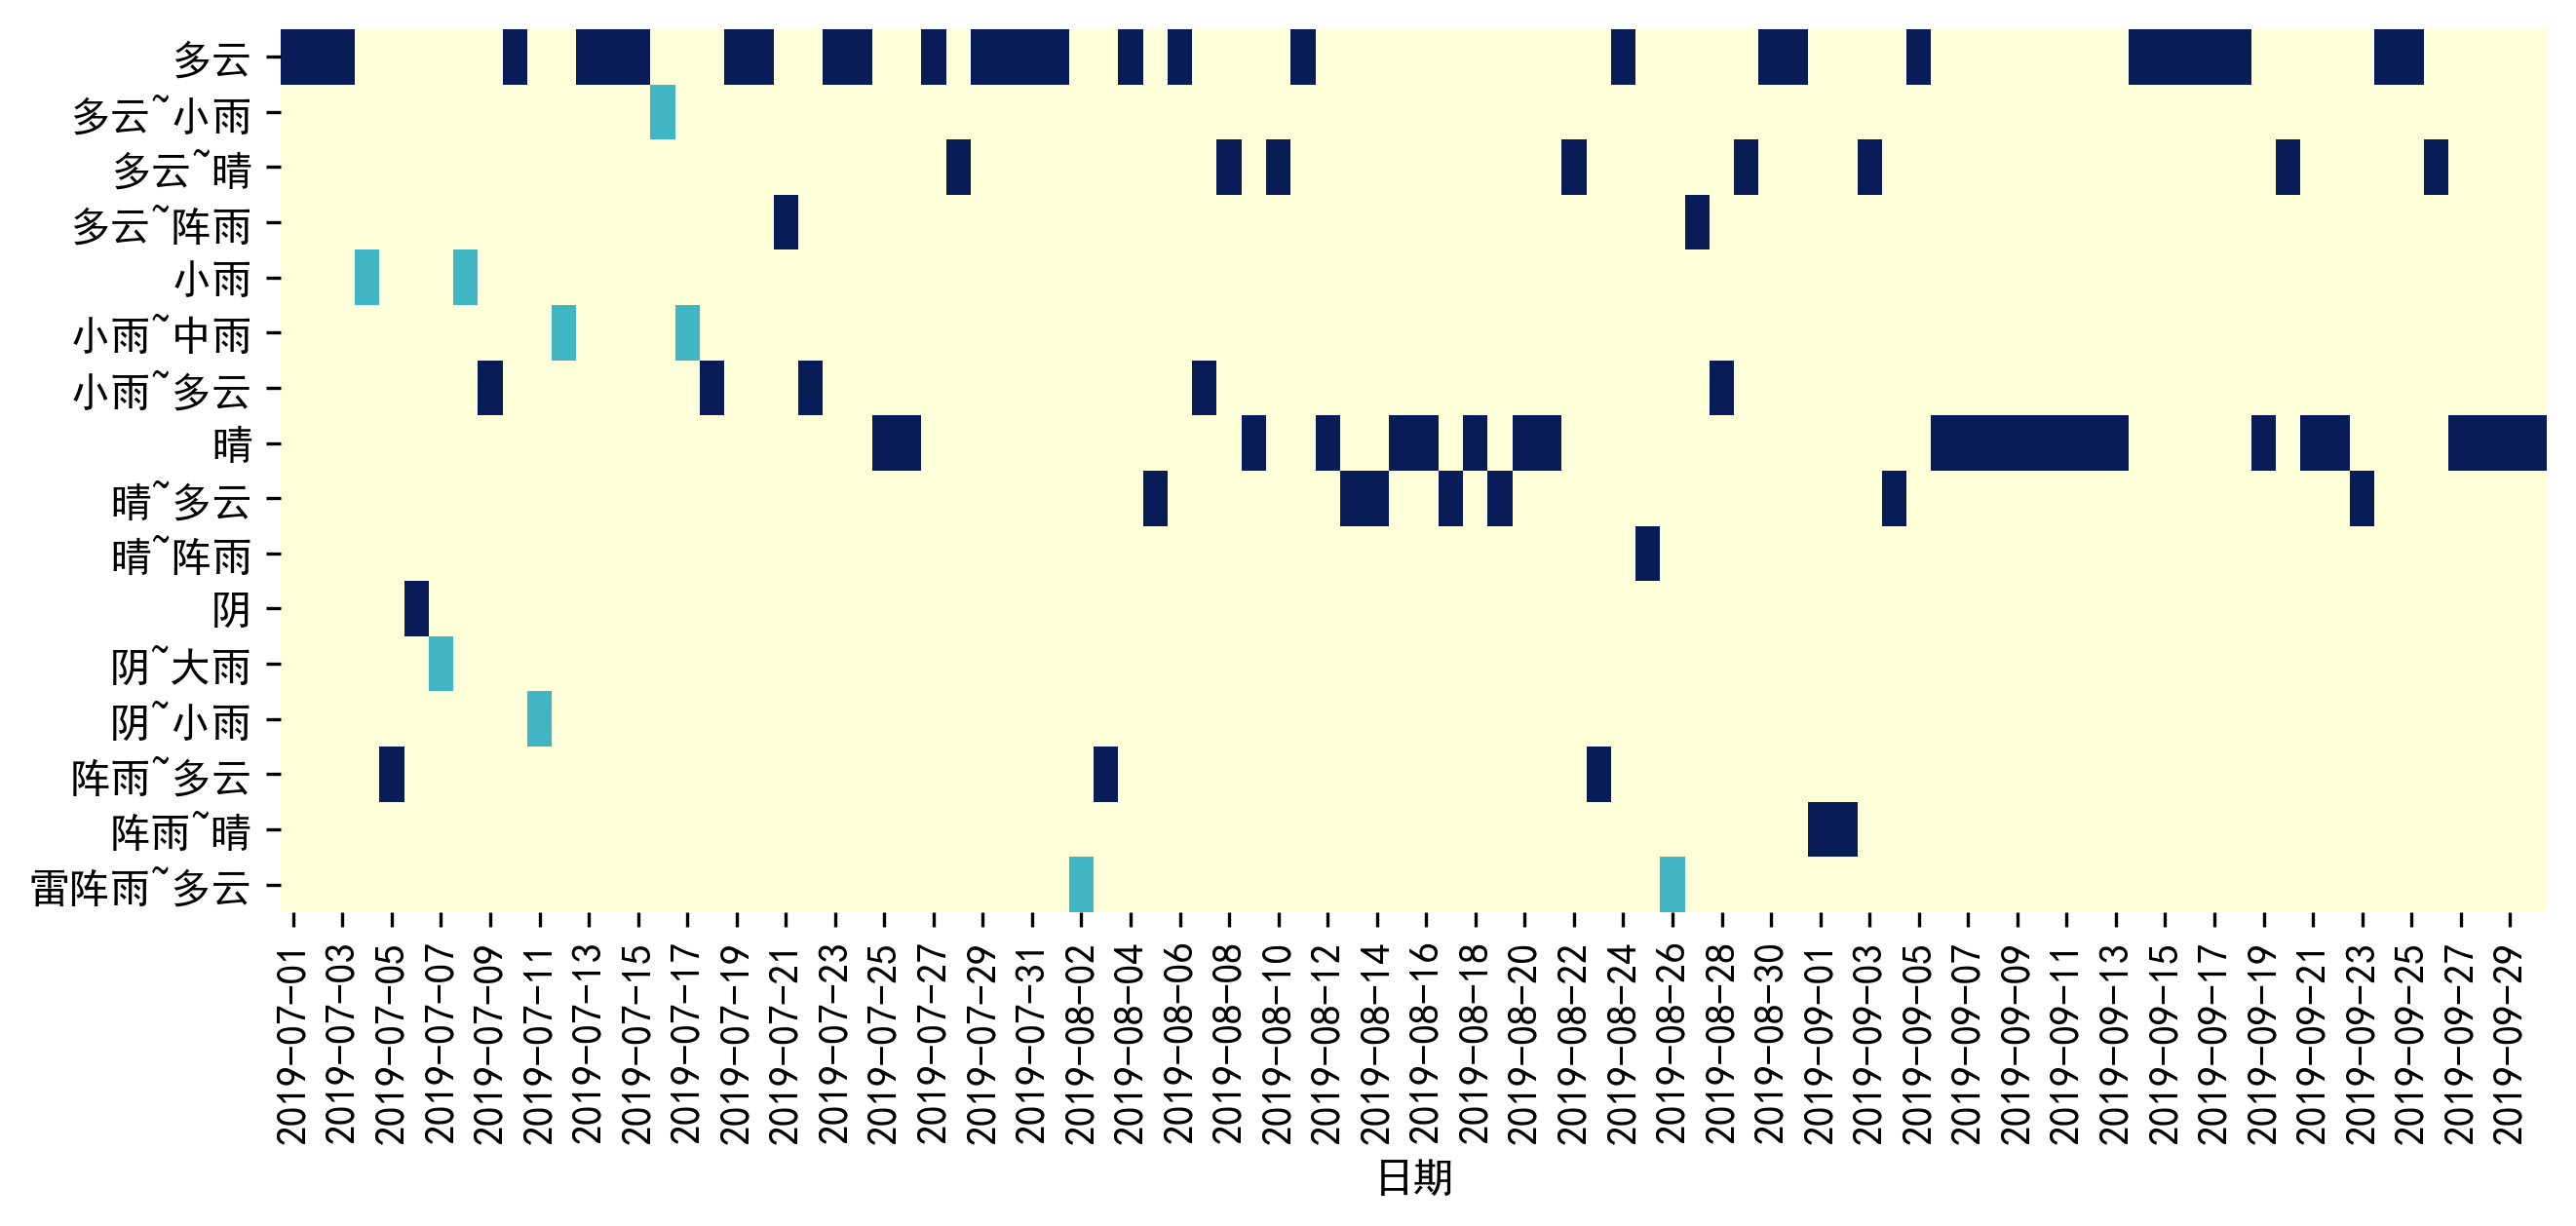

In [95]:
plt.figure(dpi=300,figsize=[10,4])
sns.heatmap(pdata,cbar=False,cmap='YlGnBu')
plt.savefig(picOut+'天气分布热力图')

In [85]:
data_all=pd.read_csv('../../output/paper/tra_linkid_aux/bufR=2e-05.csv')
data_all

,pid,tid,fid,lon,lat,timestamp,speed,type,acc,bearing,heading,hour,month,day,velocity,velocity1,maxspeed,link_id
0,15,4484,2680,114.262064,30.578585,1564483732,25.2,0,4,57.0,1,18,7,30,64.754229,40.153860,40,28833560-1
1,11,4520,3191,114.262064,30.578585,1563953961,28.8,0,5,60.0,1,15,7,24,63.438228,46.991280,40,28833560-1
2,12,4520,3191,114.262064,30.578585,1563953968,25.2,0,6,63.0,1,15,7,24,0.000000,3.184880,40,28833560-1
3,24,3988,11442,114.263161,30.579038,1563978613,21.6,0,16,159.0,1,22,7,24,37.801080,31.715136,40,28833560-1
4,0,2536,13044,114.262588,30.578841,1564488629,0.0,1,30,0.0,1,20,7,30,-9999.000000,-9999.000000,40,28833560-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4817265,14,2236,1835538,114.151255,30.620618,1564152826,32.4,0,4,86.0,1,22,7,26,36.984677,38.256484,40,229772464-0
4817266,0,3549,1836895,114.153040,30.620202,1564205362,7.2,0,19,0.0,1,13,7,27,-9999.000000,-9999.000000,40,229772464-0
4817267,16,303,1840937,114.153317,30.620061,1563776139,32.4,0,6,125.0,1,14,7,22,36.438159,-9999.000000,40,229772464-0
4817268,17,3090,1842429,114.153553,30.619890,1563819159,54.0,0,8,132.0,1,2,7,23,39.807636,-9999.000000,40,229772464-0


In [86]:
test1=data_all[pd.to_datetime(data_all.timestamp+28800,unit='s').dt.date==pd.to_datetime('2019-08-02')]

In [87]:
test2=data_all[pd.to_datetime(data_all.timestamp+28800,unit='s').dt.date==pd.to_datetime('2019-08-09')]

In [88]:
test1=test1[(test1.speed>0)&(test1.speed<120)]
test2=test2[(test2.speed>0)&(test2.speed<120)]

In [89]:
test1.groupby('link_id').count().reset_index().loc[2332,:]

link_id      456261692-2
pid                   16
tid                   16
fid                   16
lon                   16
lat                   16
timestamp             16
speed                 16
type                  16
acc                   16
bearing               16
heading               16
hour                  16
month                 16
day                   16
velocity              16
velocity1             16
maxspeed              16
Name: 2332, dtype: object

In [90]:
testlink1=test1[test1.link_id=='456191681-0']

In [91]:
testlink2=test2[test2.link_id=='456191681-0']

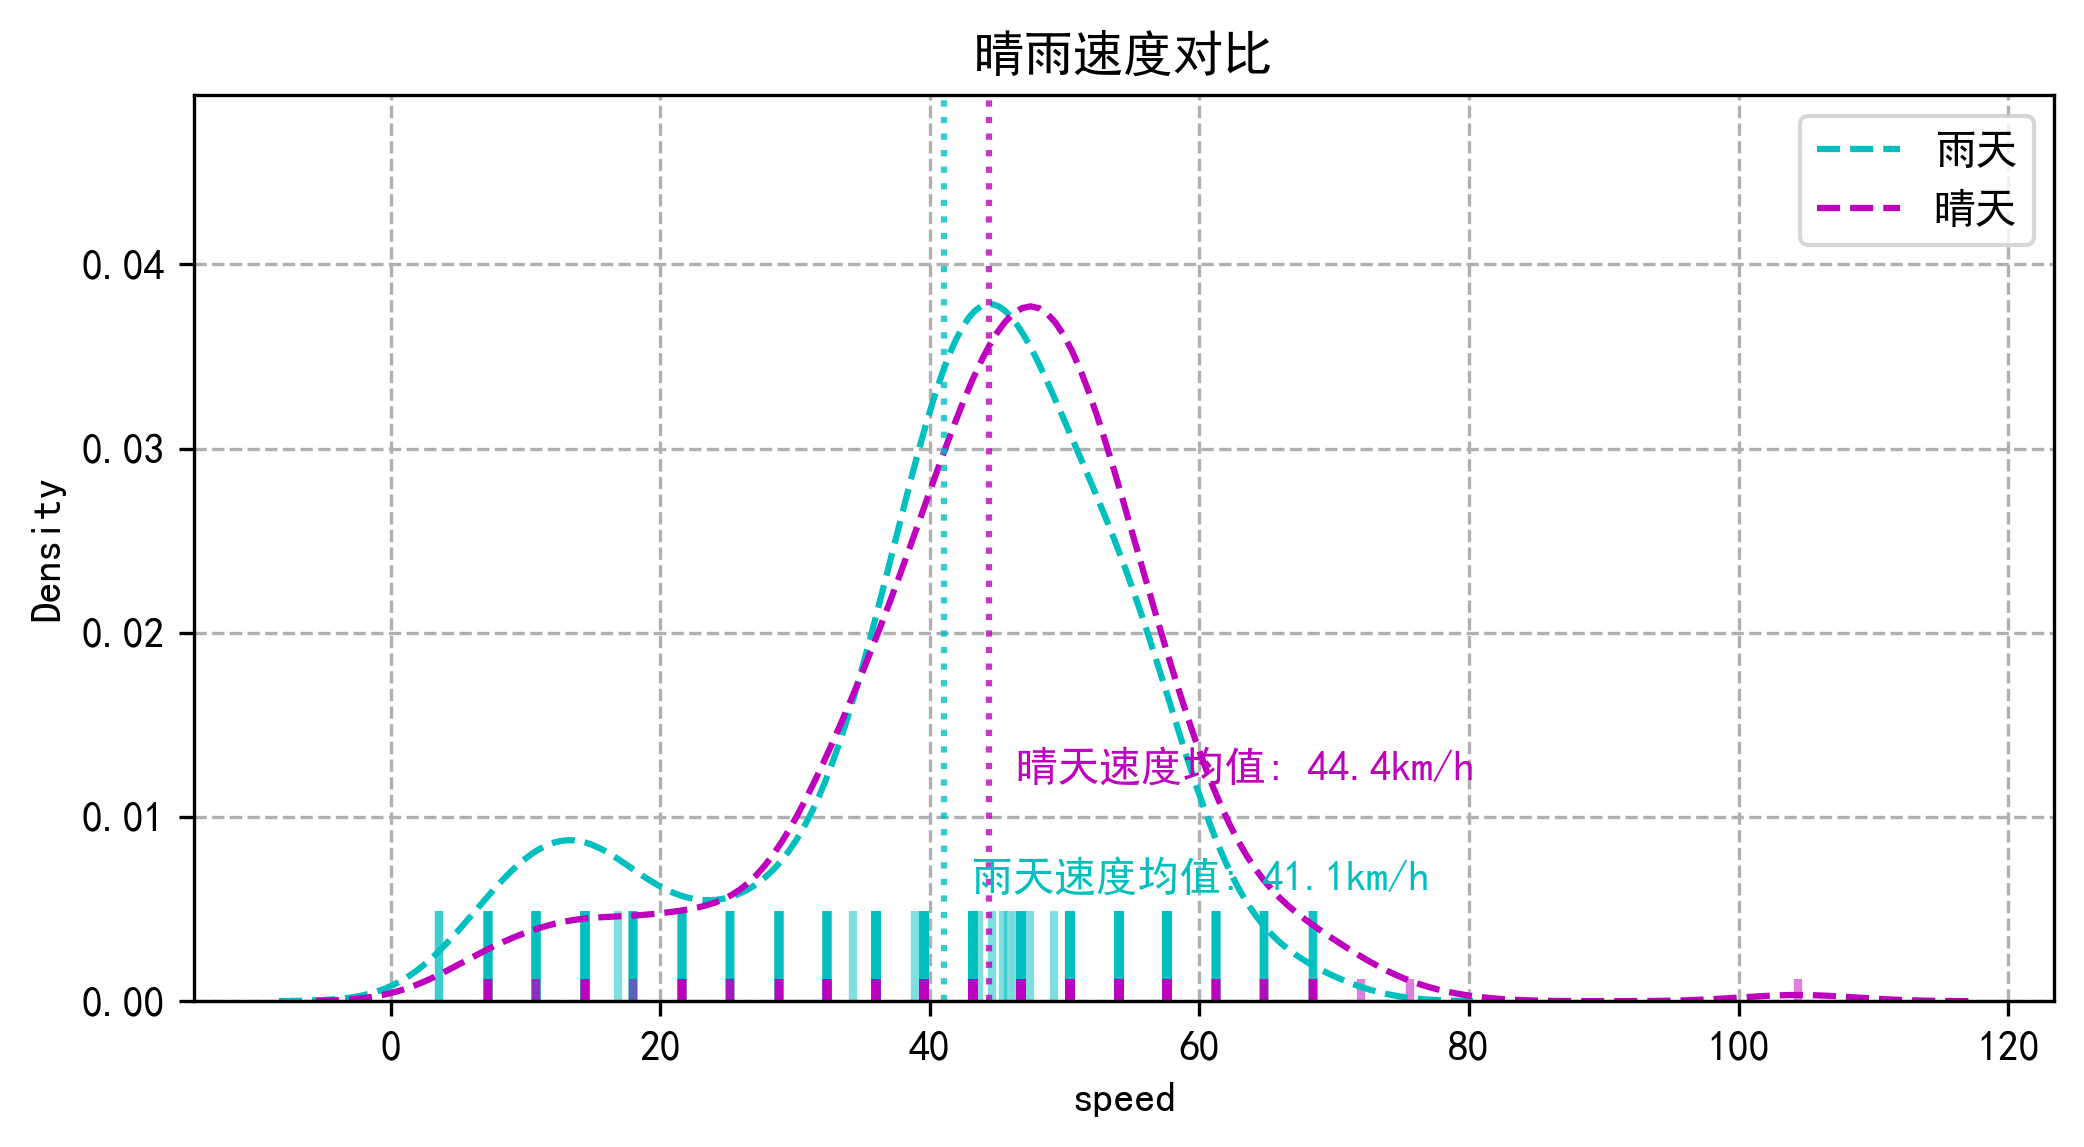

In [94]:
# sns.set_style('white')
# 图表风格设置
# 风格选择包括："white", "dark", "whitegrid", "darkgrid", "ticks"
rainy=testlink1.speed
sunny=testlink2.speed
rainy_mean=rainy.mean()
sunny_mean=sunny.mean()
cs=['c','m']
plt.figure(figsize=(8,4),dpi=300)#绘制画布
sns.distplot(rainy,hist = False,kde = True,rug = True,
             rug_kws = {'color':cs[0],'lw':2,'alpha':0.5,'height':0.1} ,   # 设置数据频率分布颜色#控制是否显示观测的小细条（边际毛毯）
             kde_kws={"color": cs[0], "lw": 1.5, 'linestyle':'--'},        # 设置密度曲线颜色，线宽，标注、线形，#控制是否显示核密度估计图
             label = '雨天')


sns.distplot(sunny,hist = False,bins=6,kde = True,rug = True,
             rug_kws = {'color':cs[1],'lw':2,'alpha':0.5} , 
             kde_kws={"color": cs[1], "lw": 1.5, 'linestyle':'--'},
             label = '晴天')
# 绘制男女高度分布密度图

plt.axvline(rainy_mean,color=cs[0],linestyle=":",alpha=0.8) 
plt.text(rainy_mean+2,0.006,'雨天速度均值: %.1fkm/h' % (rainy_mean), color = cs[0])
# 绘制男运动员平均身高辅助线

plt.axvline(sunny_mean,color=cs[1],linestyle=":",alpha=0.8) 
plt.text(sunny_mean+2,0.012,'晴天速度均值: %.1fkm/h' % (sunny_mean), color = cs[1])
# 绘制女运动员平均身高辅助线
plt.legend(['雨天','晴天'])
# plt.ylim([0,0.03])
plt.grid(linestyle = '--')     # 添加网格线
plt.title("晴雨速度对比")  # 添加图表名
plt.savefig(picOut+'晴雨天速度对比')

# 地图匹配展示/问题排查

In [2]:
data0=pd.read_csv('../../output/paper/wuhan_all/tra_all_789.csv')
data1=pd.read_csv('../../output/paper/wuhan_all/tra_all1_789.csv')

In [5]:
data0

,pid,tid,roadid,fid,lon,lat,timestamp,speed,type,acc,bearing,heading,hour,month,day
0,0,154,751207790,0,114.609812,30.496618,1564384134,0.0,0,4,0.0,1,15,7,29
1,1,154,751207790,0,114.609812,30.496618,1564384173,6.0,0,14,299.0,1,15,7,29
2,2,154,751207790,0,114.609484,30.496833,1564384178,9.0,0,13,306.0,1,15,7,29
3,0,124,105737895,1,114.390502,30.636499,1564357343,0.0,0,17,39.0,1,7,7,29
4,1,124,105737895,1,114.390502,30.636499,1564357348,0.0,0,8,0.0,1,7,7,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18103949,0,1739,66527024,1848455,114.403232,30.461618,1564066526,5.0,1,30,251.0,1,22,7,25
18103950,1,1739,66527024,1848455,114.403058,30.461722,1564066529,0.0,0,25,0.0,0,22,7,25
18103951,2,1739,66527024,1848455,114.403156,30.461664,1564066533,1.0,0,18,350.0,0,22,7,25
18103952,3,1739,103496300,1848455,114.403400,30.459671,1564066551,1.0,0,9,230.0,0,22,7,25


In [9]:
data1

,pid,rid,timestamp,lat,lon,bearing,speed,bearing1,speed_cal,lat_old,lon_old,fid,hour,month,day
0,0,751207790,1564384134,30.497218,114.610335,0.0,0.0,0.00,0.00,30.496618,114.609812,0,15,7,29
1,1,751207790,1564384173,30.496656,114.609901,299.0,6.0,213.61,1.98,30.496618,114.609812,0,15,7,29
2,2,751207790,1564384178,30.496873,114.609519,306.0,9.0,303.46,9.00,30.496833,114.609484,0,15,7,29
3,0,105737895,1564357343,30.636499,114.390550,39.0,0.0,39.00,0.00,30.636499,114.390502,1,7,7,29
4,1,105737895,1564357348,30.636453,114.390703,0.0,0.0,109.55,0.32,30.636499,114.390502,1,7,7,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18103949,15,425879629,1565050276,30.536584,114.417196,302.0,15.0,302.47,15.61,30.536611,114.417214,1848454,8,8,6
18103950,16,425879629,1565050300,30.538356,114.413809,301.0,17.0,301.29,17.00,30.538385,114.413830,1848454,8,8,6
18103951,0,352076088,1565051046,30.621462,114.350636,313.0,4.0,313.00,4.00,30.621430,114.350600,1848455,8,8,6
18103952,1,352076088,1565051060,30.621920,114.350031,310.0,6.0,311.30,9.59,30.621876,114.349989,1848455,8,8,6
